In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/PhC-C2DH-U373.zip
replace PhC-C2DH-U373/01/t000.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PhC-C2DH-U373/01/t001.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [ ]:
from PIL import Image

# Cargo Train y Val

Se cargan los datos para entrenar la red y los datos de validación. Se cropean las imagenes a un tamaño de entrada de 520x696px. y se nota que tienen un canal de colores (escala de grises)

In [ ]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [ ]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [ ]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar
Visualizacion de datos, EDA

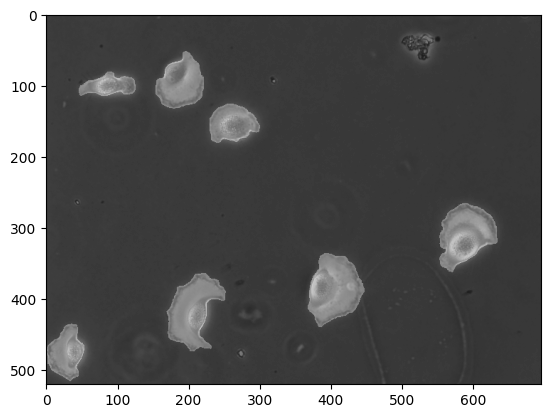

In [ ]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.3)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [ ]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(train_images.shape)
print(val_images.shape)


(115, 520, 696, 2)
(115, 520, 696, 2)
(115, 520, 696)
(115, 520, 696)


Notamos que cuando antes teniamos un arreglo de 115 elementos, siendo los mismos imagenes de 520x696 px., ahora armamos dos "matrices" donde las columnas son datos y mascaras, una matriz para train y otra para val, donde la imagen y mascara de cada fila se corresponden.

In [ ]:
x_train[0,:,:,0].max()

0.7254901960784313

In [ ]:
len(x_train)

115

115 imagenes de entrenamiento

Visualizamos una imagen con su mascara

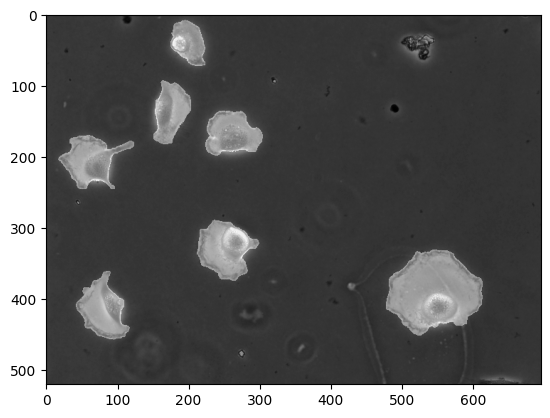

In [ ]:
plt.imshow(x_train[5,:,:,0], cmap="gray")
plt.imshow(x_train[5,:,:,1], cmap="gray", alpha = 0.4)

In [ ]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions
Se procede con el armado de una red convolucional basica. Cuenta con 16 filtros de entrada, cada uno con tamaño 10x10 y se utiliza un padding = 'same'. Las funciones de activacion para capas invisibles son relu y para la capa de salida se una una sigmoidea. Notamos como entre cada capa se aumenta la tasa de dilatación, lo que causa que el campo perceptual de nuestras neuronas aumente a medida que avanza el flujo en la red.

In [ ]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación
Se definen las funciones que devuelven un modelo con capas de preprocesamiento (aumentado de datos) al comienzo.
Además se incluye una etapa de cropeo de la imagen que resultará en que las imagenes a la entrada tengan un tamaño estandarizado de 512x512 pixeles.


In [ ]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

Probamos visualizando un dato cualquiera..

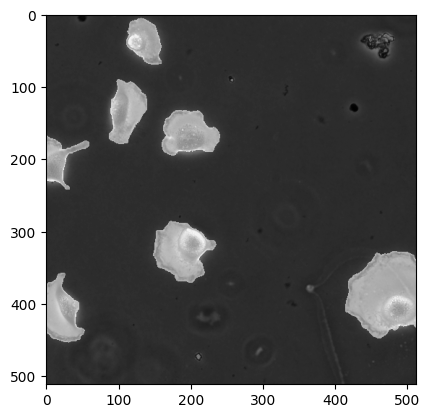

In [ ]:
preproc = get_preproc()
aux_elem = preproc(x_train[5])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

##Coeficiente de Dice
Se definen las funciones para obtener en base a las predicciones realizadas y los "ground truths", tanto el coeficiente de dice como la loss de mismo.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

##Definición de la clase modelo de segmentación
Se define la clase a partir de la cual armaremos nuestros modelos. Contiene metodos para el entrenamiento, guardado de metricas y otras propiedades utiles a la hora de armar un modelo.

In [ ]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [ ]:
red_falopa = get_red_seg()

In [ ]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [ ]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
len(x_val)

115

In [ ]:
#model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

In [ ]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

In [ ]:
pred.numpy().max()

In [ ]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

## Definicion formal de nuestra red U-Net
Definiremos las funciones que crearan los bloques principales de la U-Net, a partir de los parametros que se reciban.
Entre ellos se encuentran:
- Dimensiones de la imagen de entrada
- Canales de salida
- Profundidad de la red (nro de pools/upsamplings)
- Filtros de entrada
- Funcion de activación a lo largo de la red
- Tasa de dropout
- Batch normalization, maxpooling,

In [ ]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

#Funcion Conv_block
Se arma un bloque convolucional. En este paso se realizan dos convoluciones en "serie". Se introducen capas de normalizacion y dropout entre las mismas en caso de estar activadas.
En el esquema general de la U-Net, agregar un bloque de convoluciones equivale a un desplazamiento "hacia la derecha". En la misma, se preservan las dimensiones de la imagen, y se agregan en una

In [ ]:
def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

##Funcion level_block
Quizas la funcion mas fundamental de nuestro armado de la red. Esta funcion recibnira la altura desde la que se la llama, las dimensiones de las que viene y a las que va, y dependiendo de su altura define si
a) Se invoca un bloque_conv, para luego reducir mediante maxpooling ("bajar de nivel" en el diagrama)
b) Se debe hacer un upsample en 2D seguido de una convolucion, y una concatenacion de la salida de la capa "del otro lado de la red", skip connects.
c) Una convolucion transpuesta en 2D, seguido de la concatenacion y posterior bloque convolucional.
Notamos que esta funcion se llamará recursivamente y cada llamado se "mueve" verticalmente por la red, una vez por nivel y llamara a conv_bloq para moverse horizontalmente.

In [ ]:
def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m



##Funcion UNet
Es la ultima funcion para armar nuestro modelo propiamente. Se agrega la capa de entrada, se crea la forma de U mediante level block. Se ubica a la salida una capa convolucional con funcion de activacion sigmoidea para obtener las predicciones a la salida para cada pixel de la imagen.

In [ ]:
def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

###Implementacion
Se implementa la arquitectura UNet de la siguiente manera. Notar que agregamos llamados a las funciones de data augmentation y armamos el modelo valiendonos de la funcion SegmentationModel.

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

Utilizamos Adam como optimizador por su buen rendimiento y estabilidad con LR=1e-4

In [ ]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

Entrenamos nuestro modelo...
Notar que se arma una lista total y luego se divide con validation_split, se define un batchsize adecuado y se incluyen callbacks.

In [ ]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Callback to reduce LR if we find a plateau in validation accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00005)

callbacks = [early_stop_callback, reduce_lr]

In [ ]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, verbose = 1, callbacks=callbacks)

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
red_unet.summary()

#Resumen de la red
Con la utilidad brindada por keras podemos graficar las capas de nuestra arquitectura U-Net, donde termina de quedar claro como funciona el bloque conv__block (dos convoluciones en serie) y level_block. Vemos en las primeras capas la etapa de encoding, en la que se baja la resolucio espacial (ancho y alto bajan, mediante max pooling) pero aumenta la profundidad al rescatar feratures cada vez mas finos. Vemos tambien las skip connections, que se utilizan poder recibir un contexto driectamente de la entrada (previo a la convolucion de su nivel). Sirven para, principalmente, dar un "contexto" mas fiel a los diferentes niveles en el decoder (tramo de salida). Se utiliza en la el decoding, upsampling en 2D en lugar de convoluciones en 2D transpuestas (operacion inversa a la convolucion), lo que reduce un poco la complejidad con respecto a la otra alternativa.

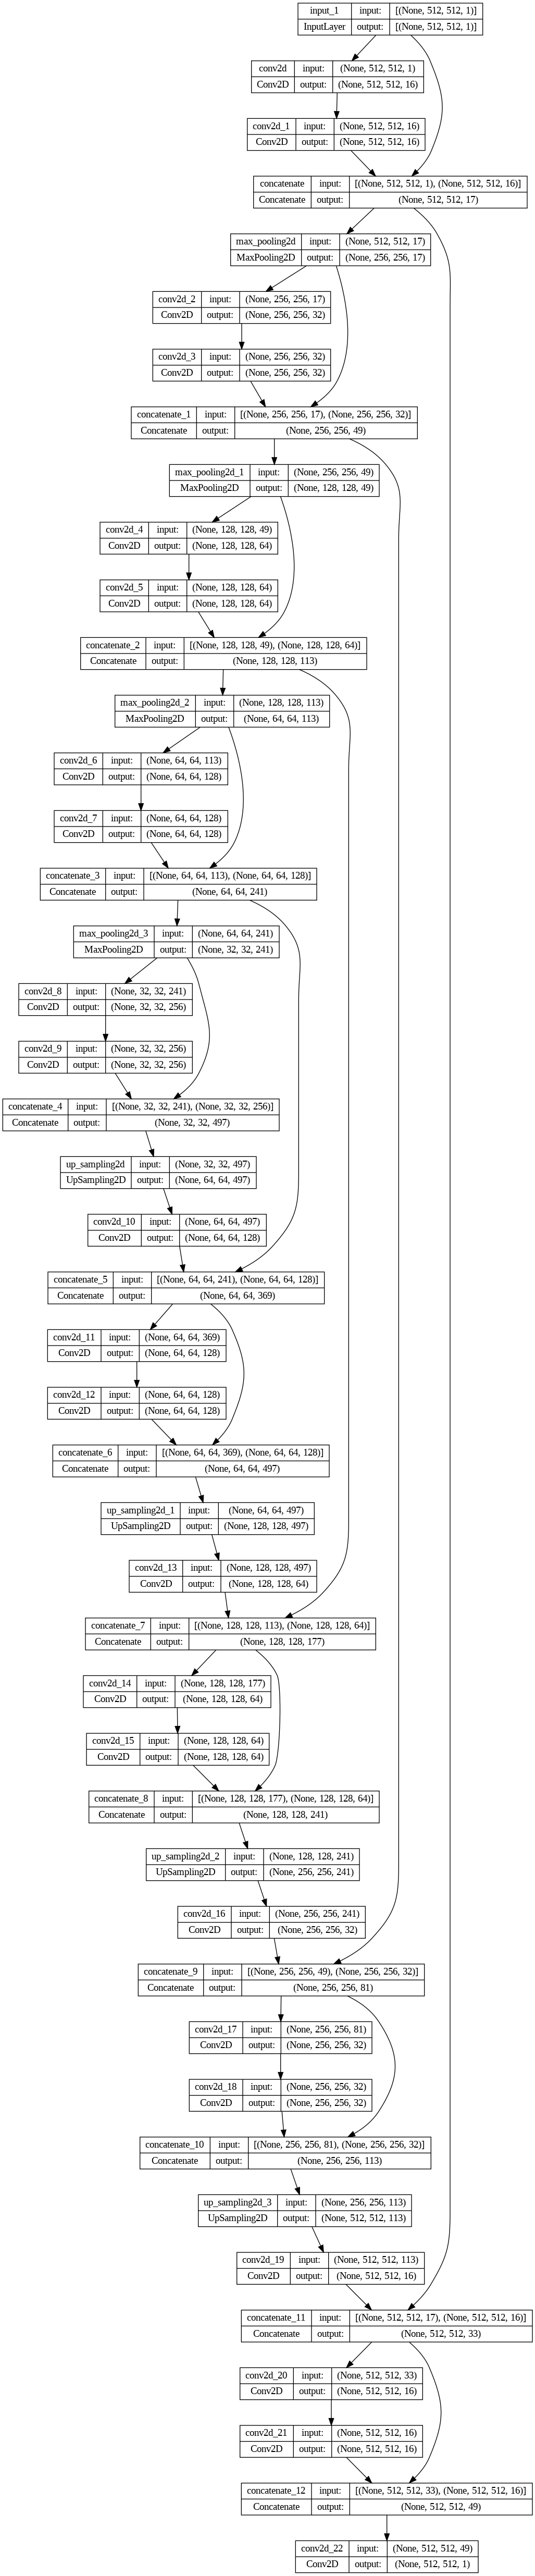

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(red_unet, show_shapes=True, to_file='model.png')

#Esquema U-Net, en codigo

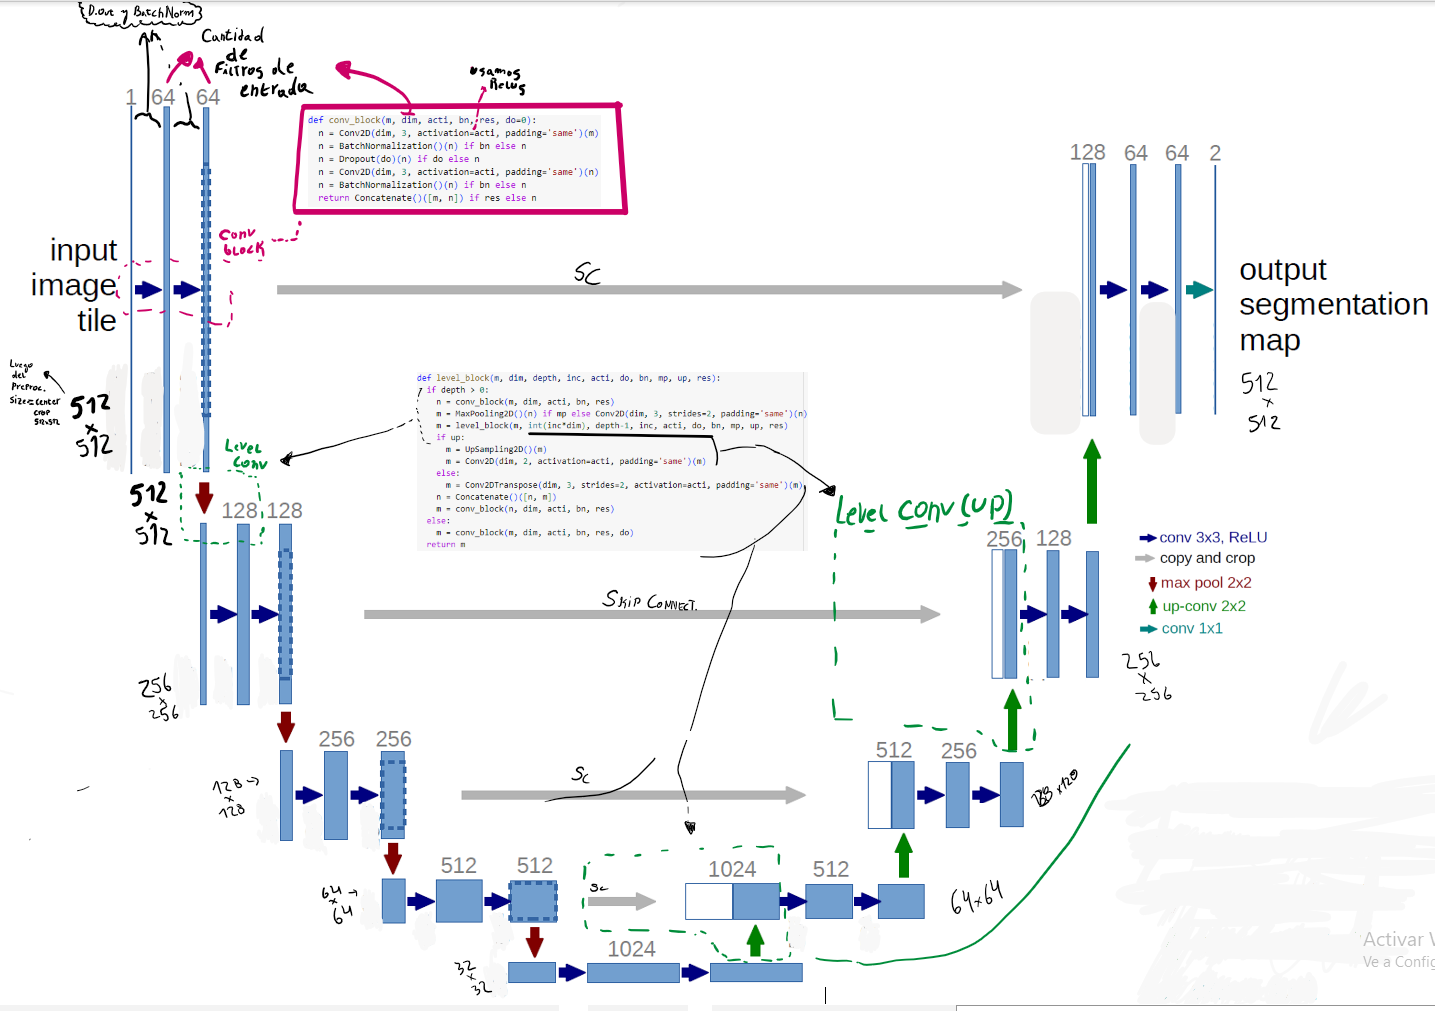

###Predicciones y pruebas
Se separan algunos datos, y se realizan predicciones sobre los mismos, con el fin de visualizar algunas de las mismas y evaluar los resultados obtenidos.

In [ ]:
n_preds = 3
aux = preproc_unet_val(x_val[0:n_preds,:,:,:])
pred = red_unet(aux[0:n_preds,:,:,0])
pred.shape

In [ ]:
plt.imshow(aux[1,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[1,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[1,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()


Calculamos para las predicciones realizadas, cuanto da la media del coeficiente de dice.

In [ ]:
dice = []
for i in range(n_preds):
    dice += [dice_coef(aux[i,:,:,1], pred[i,:,:,0], smooth=1e-6)]
print("La media del coeficiete de DICE con el modelo inicial es: ", np.array(dice).mean())

###Pruebas

Primera modificacion. Bajamos la profundidad maxima a 3, lo que significa que nuestro feature map mas pequeño ahora sera de $\frac{512x512}{2^3}=64x64$pixeles.Lo cual pareciera apropiado si consideramos que no se requiere una definicion tan marcada para el tamaño que tienen los datos en las imagenes.
En segundo lugar, se agrando la profundidad de la red, contando ahora con 32 filtros que nos aportaran granularidad y mayor nivel de detalle para cada capa, y agregamos tambien una capa de dropout para regularizar y optimizar en tiempo de entrenamiento.

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
test2_unet = UNet(
    img_shape,
    start_ch = 32,
    depth = 3,
    dropout = 0.2,
    residual = True
)
modeltest2_unet = SegmentationModel(preproc_unet, test2_unet,preproc_unet_val)

In [ ]:
modeltest2_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
test2_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 512, 512, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 32  9248        ['conv2d_23[0][0]']              
                                )                                                           

In [ ]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Callback to reduce LR if we find a plateau in validation accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00005)

callbacks = [early_stop_callback, reduce_lr]

In [ ]:
modeltest2_unet.fit(np.vstack([x_train, x_val]),batch_size=4, epochs=100, validation_split = 0.5, verbose = 1, callbacks=callbacks)

Epoch 1/100
29/29 [==============================] - 54s 1s/step - loss: 0.4809 - val_loss: 0.2604 - lr: 1.0000e-04
Epoch 2/100
29/29 [==============================] - 22s 775ms/step - loss: 0.3411 - val_loss: 0.2061 - lr: 1.0000e-04
Epoch 3/100
29/29 [==============================] - 23s 789ms/step - loss: 0.3277 - val_loss: 0.1991 - lr: 1.0000e-04
Epoch 4/100
29/29 [==============================] - 23s 796ms/step - loss: 0.2518 - val_loss: 0.0713 - lr: 1.0000e-04
Epoch 5/100
29/29 [==============================] - 23s 802ms/step - loss: 0.1511 - val_loss: 0.0666 - lr: 1.0000e-04
Epoch 6/100
29/29 [==============================] - 23s 804ms/step - loss: 0.1249 - val_loss: 0.0539 - lr: 1.0000e-04
Epoch 7/100
29/29 [==============================] - 23s 810ms/step - loss: 0.0990 - val_loss: 0.0444 - lr: 1.0000e-04
Epoch 8/100
29/29 [==============================] - 23s 809ms/step - loss: 0.0813 - val_loss: 0.0369 - lr: 1.0000e-04
Epoch 9/100
29/29 [==============================] 

In [ ]:
aux = preproc_unet_val(x_val[0:3,:,:,:])
pred = test2_unet(aux[0:3,:,:,0])
pred.shape

TensorShape([3, 512, 512, 1])

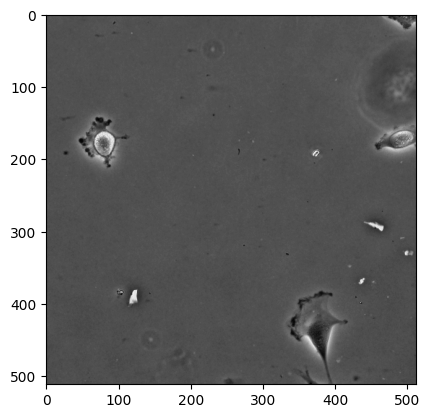

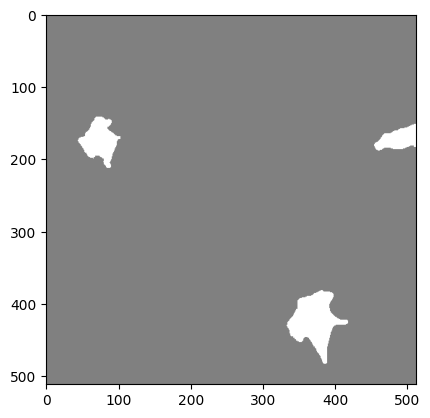

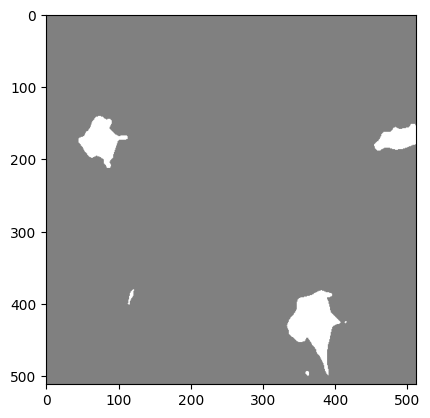

In [ ]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

In [ ]:
dice = []
for i in range(3):
    dice += [dice_coef(aux[i,:,:,1], pred[i,:,:,0], smooth=1e-6)]
print("La media del coeficiete de DICE con el modelo inicial es: ", np.array(dice).mean())

0.94386643

##Testeo otro modelo
Pruebo manteniendo cantidad alta de filtros, aumentando dropout

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
test3 = UNet(
    img_shape,
    start_ch = 64,
    depth = 2,
    dropout = 0.7,
    residual = True,
    batchnorm = True
)
modeltest3 = SegmentationModel(preproc_unet, test3,preproc_unet_val)


In [ ]:
modeltest3.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
test3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 512, 512, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 512, 512, 64  256        ['conv2d_59[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Callback to reduce LR if we find a plateau in validation accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00005)

callbacks = [early_stop_callback, reduce_lr]

In [ ]:
modeltest3.fit(np.vstack([x_train, x_val]),batch_size=4, epochs=100, validation_split = 0.5, verbose = 1, callbacks=callbacks)

Epoch 1/100
29/29 [==============================] - 141s 3s/step - loss: 0.4318 - val_loss: 0.2374 - lr: 1.0000e-04
Epoch 2/100
29/29 [==============================] - 58s 2s/step - loss: 0.3272 - val_loss: 0.1957 - lr: 1.0000e-04
Epoch 3/100
29/29 [==============================] - 58s 2s/step - loss: 0.3125 - val_loss: 0.1691 - lr: 1.0000e-04
Epoch 4/100
29/29 [==============================] - 59s 2s/step - loss: 0.2171 - val_loss: 0.0678 - lr: 1.0000e-04
Epoch 5/100
29/29 [==============================] - 59s 2s/step - loss: 0.1486 - val_loss: 0.0623 - lr: 1.0000e-04
Epoch 6/100
29/29 [==============================] - 59s 2s/step - loss: 0.1321 - val_loss: 0.0590 - lr: 1.0000e-04
Epoch 7/100
29/29 [==============================] - 59s 2s/step - loss: 0.1088 - val_loss: 0.0707 - lr: 1.0000e-04
Epoch 8/100
29/29 [==============================] - 59s 2s/step - loss: 0.0962 - val_loss: 0.0439 - lr: 1.0000e-04
Epoch 9/100
29/29 [==============================] - 59s 2s/step - loss

In [ ]:
npreds = 3
aux = preproc_unet_val(x_val[0:npreds,:,:,:])
pred = test3(aux[0:npreds,:,:,0])
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

In [ ]:
dice = []
for i in range(npreds):
    dice += [dice_coef(aux[i,:,:,1], pred[i,:,:,0], smooth=1e-6)]
np.array(dice).mean()